In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import scipy

from statsmodels.formula.api import ols

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output

%matplotlib inline

In [2]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.regularizers import WeightRegularizer, l1, l2
from keras.callbacks import EarlyStopping, Callback

from keras.layers.normalization import BatchNormalization

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
from libscores import auc_metric

In [5]:
class WatchlistCallback(Callback):
    def __init__(self, watchlist, eval_metric, epoch_no=10):
        super(Callback, self).__init__()

        self.epoch_no = epoch_no
        self.X, self.y = watchlist
        self.eval_metric = eval_metric
        self.scores = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.epoch_no == 0:
            y_pred = self.model.predict(self.X, verbose=0)
            score = self.eval_metric(self.y, y_pred)
            self.scores.append(score)
            self.epochs.append(epoch)

            print "score: %0.6f (epoch no %d)" % (score, epoch)  

class StatusCallback(Callback):    
    def __init__(self, epoch_total):
        super(Callback, self).__init__()
        self.progress = tqdm(total=epoch_total)
        
    def on_epoch_end(self, epoch, logs={}):
        self.progress.update(1)

    def __enter__(self): 
        return self

    def __exit__(self, type, value, traceback):
        self.progress.close()

In [6]:
def read_info(file_name):
    result = []
    
    for line in file(file_name):
        key, value = line.strip().split('=')
        key = key.strip()
        value = value.strip().strip("'")
        if value.isdigit():
            value = int(value)
        result.append((key, value))
    
    return dict(result)

In [7]:
public = read_info('data/set1_evita/evita_public.info')
public

{'feat_num': 3000,
 'feat_type': 'Binary',
 'has_categorical': 0,
 'has_missing': 0,
 'is_sparse': 1,
 'label_num': 2,
 'metric': 'auc_metric',
 'name': 'evita',
 'target_num': 1,
 'target_type': 'Categorical',
 'task': 'binary.classification',
 'test_num': 14000,
 'time_budget': 1200,
 'train_num': 20000,
 'usage': 'AutoML challenge 2014',
 'valid_num': 8000}

In [8]:
dim = public['feat_num']

def read_features(fine_name):
    result = list()
    for line in file(fine_name):
        row = [int(f) - 1 for f in line.strip().split(' ') if f]
        result.append(row)
    
    rnum = len(result)
    X = scipy.sparse.dok_matrix((rnum, dim), dtype=np.int)
    for idx, row in enumerate(result):
        X[idx, row] = 1

    return scipy.sparse.csr_matrix(X)

In [26]:
X = read_features('data/set1_evita/evita_train.data')
y = np.fromfile('data/set1_evita/evita_train.solution', sep='\n', dtype=np.int)

X_valid = read_features('data/set1_evita/evita_valid.data')
X_test  = read_features('data/set1_evita/evita_test.data')

print X.shape, y.shape
print X_valid.shape, X_test.shape

(20000, 3001) (20000,)
(8000, 3001) (14000, 3001)


In [36]:
train_size = 0.8
EPOCHS = 2000
dim = X.shape[1]

cv = StratifiedShuffleSplit(y, n_iter=1, train_size=train_size, random_state=11)
train, test = next(cv.__iter__())

X_train_svd = X[train].toarray() #svd.transform(X_input[train])
X_test_svd = X[test].toarray() # svd.transform(X_input[test])

In [46]:
model = Sequential()
model.add(Dense(input_dim=dim, output_dim=1000, init='uniform', W_regularizer=l1(0.0001)))
model.add(Activation('sigmoid'))

model.add(Dense(input_dim=1000, output_dim=200, init='uniform'))
model.add(Activation('sigmoid'))

model.add(Dense(input_dim=200, output_dim=1, init='uniform'))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd')

watchlist = (X_test_svd, y[test].reshape(-1, 1))
watchlist_callback = WatchlistCallback(watchlist, eval_metric=auc_metric, epoch_no=1)

In [ ]:
model.fit(X_train_svd, y[train], nb_epoch=EPOCHS, batch_size=250, 
          callbacks=[watchlist_callback], verbose=0)

score: -0.084993 (epoch no 0)
score: -0.073765 (epoch no 1)
score: -0.061724 (epoch no 2)
score: -0.051509 (epoch no 3)
score: -0.040654 (epoch no 4)
score: -0.029762 (epoch no 5)


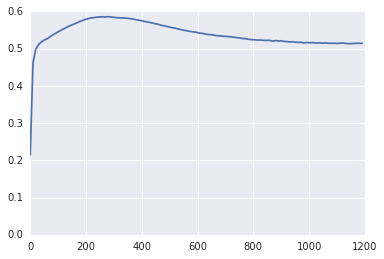

In [15]:
plt.plot(watchlist_callback.epochs, watchlist_callback.scores)
plt.ylim(0, 0.6)
plt.show()

In [18]:
EPOCHS = 260
dim = X_input.shape[1]

model = Sequential()
model.add(Dense(input_dim=dim, output_dim=300, init='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('sigmoid'))

model.add(Dense(input_dim=300, output_dim=1, init='uniform'))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd')

with StatusCallback(epoch_total=EPOCHS) as status:
    model.fit(X_input.toarray(), y, nb_epoch=EPOCHS, batch_size=250, callbacks=[status], verbose=0)

In [19]:
y_valid_score = model.predict(X_valid.toarray())
y_test_score = model.predict(X_test.toarray())

In [20]:
np.savetxt('submission/evita_valid.predict', y_valid_score, fmt='%0.18f')
np.savetxt('submission/evita_test.predict', y_test_score, fmt='%0.18f')